In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

In [2]:
def chi_fit(X, Y, dY, sigma=1, force_intercept=False):
    """
    Does linear regression y = ax + b using least chi square method
    
    returns a, b, da, db
    """
    
    if len(X) != len(Y):
        raise ValueError("dimensons of X and Y don't match")
    
    L = len(X)
    
    if force_intercept:
        def f(a):
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i])) / dY[i]

            return ret

        result = scipy.optimize.least_squares(f, (1,), ftol=1e-15, xtol=1e-15, gtol=1e-15)
        a, = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_):
            return np.sum(f((a_))**2)

        da = 0
        inc_a = a/10000

        while sigma > chi_2(a+da) - chi_2_min:
            da += inc_a
        
        print('Weighted chi_2 :', chi_2_min / (len(X) - 1))
        return a, 0, da, 0
    else:
        def f(coeffs):
            a, b = coeffs
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i] + b)) / dY[i]

            return ret

        result = scipy.optimize.least_squares(f, (1, 1), ftol=1e-8, xtol=1e-8, gtol=1e-8)
        a, b = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_, b_):
            return np.sum(f((a_, b_))**2)

        da, db = 0, 0
        inc_a = 0.001
        inc_b = 0.001

        while sigma > chi_2(a+da, b) - chi_2_min:
            da += inc_a

        while sigma > chi_2(a, b+db) - chi_2_min:
            db += inc_b
        
        print('Weighted chi_2 :', chi_2_min / (len(X) - 2))
        return a, b, da, db
        

In [3]:
FPS = 30
g = 9.81
l = 0.101
dl = 0.001
balls = pd.read_csv('balls.csv', index_col=0)
times = pd.read_csv('times.csv')
balls['d_mean'] = ((balls['d1'] + balls['d2'] + balls['d3'])/3).round(2)
print(balls.loc['m3':].style.to_latex())

\begin{tabular}{lrrrr}
 & d1 & d2 & d3 & d_mean \\
ball &  &  &  &  \\
m3 & 0.840000 & 0.840000 & 0.840000 & 0.840000 \\
m4 & 0.820000 & 0.820000 & 0.820000 & 0.820000 \\
m5 & 0.760000 & 0.760000 & 0.760000 & 0.760000 \\
m6 & 0.820000 & 0.880000 & 0.720000 & 0.810000 \\
m7 & 0.920000 & 0.880000 & 0.940000 & 0.910000 \\
m8 & 0.880000 & 0.920000 & 0.880000 & 0.890000 \\
m9 & 0.900000 & 0.900000 & 0.880000 & 0.890000 \\
m10 & 0.880000 & 0.880000 & 0.860000 & 0.870000 \\
m11 & 0.960000 & 0.920000 & 0.920000 & 0.930000 \\
m12 & 1.000000 & 1.040000 & 0.880000 & 0.970000 \\
m13 & 0.880000 & 0.900000 & 0.880000 & 0.890000 \\
m14 & 0.940000 & 0.980000 & 1.000000 & 0.970000 \\
m15 & 0.900000 & 0.900000 & 0.900000 & 0.900000 \\
\end{tabular}



In [4]:
def shit_to_frames(t):
    return int(t) * FPS + round((t - int(t)) * 100)

In [5]:
def rho(T):
    return 1269 - 0.43 * T

In [6]:
times_in_frames = pd.DataFrame(columns=['ball', 'T', 't1', 't2'])
times_in_frames['ball'] = times['ball']
times_in_frames['T'] = times['T'].round(2)
times_in_frames['t1'] = times['t2'].map(shit_to_frames) - times['t1'].map(shit_to_frames)
times_in_frames['t2'] = times['t3'].map(shit_to_frames) - times['t2'].map(shit_to_frames)

times_in_seconds = pd.DataFrame(columns=['ball', 'T', 't1', 't2'])
times_in_seconds[['ball', 'T']] = times_in_frames[['ball', 'T']]
times_in_seconds[['t1', 't2']] = times_in_frames[['t1', 't2']] / FPS

In [7]:
data = pd.DataFrame(columns=['ball', 'T', 'v', 'dv', 'eta', 'deta', 'Re', 'tau', 'S'])
for i, ball in enumerate(times_in_seconds['ball']):
    data.loc[i, 'ball'] = ball
    data.loc[i, 'T'] = times_in_seconds.loc[i, 'T']
    
    
    t = times_in_seconds.loc[i, 't1'] + times_in_seconds.loc[i, 't2']
    dt = np.sqrt(2) / FPS
    v = 2*l/t
    dv = v * np.sqrt((dl / l)**2 + (dt / t)**2)
    
    rho_ball = 2500 if ball.startswith('s') else 7800
    rho_liquid = rho(data.loc[i, 'T'])
    
    r = balls.loc[ball, 'd_mean'] * 0.5 * 0.001
    dr = 2 * balls.loc[ball].std(ddof=0) * 0.5 * 0.001
    
    eta = (2 / 9) * (g * r**2) * (rho_ball - rho_liquid) / v
    deta = eta * np.sqrt((dv / v)**2 + (2*dr / r)**2)
    Re = rho_liquid * r * v / eta
    tau = (2 / 9) * r**2 * rho_liquid / eta
    S = v * tau
    
    data.loc[i, ['v', 'dv', 'eta', 'deta', 'Re', 'tau', 'S']] = [v, dv, eta, deta, Re, tau, S]
data

,ball,T,v,dv,eta,deta,Re,tau,S
0,s1,30.86,0.006652,0.000067,0.441046,0.021241,0.019697,0.000684,0.000005
1,s2,30.86,0.006674,0.000067,0.435376,0.008228,0.019923,0.000687,0.000005
2,s3,41.53,0.011953,0.000123,0.251121,0.002583,0.062528,0.001221,0.000015
3,s4,41.5,0.012144,0.000125,0.240145,0.004574,0.065486,0.00124,0.000015
4,s5,50.93,0.020473,0.000225,0.142913,0.002777,0.184906,0.002077,0.000043
5,s6,51.05,0.021263,0.000235,0.138941,0.001539,0.198479,0.002157,0.000046
6,s7,62.0,0.035233,0.000453,0.082556,0.002504,0.5461,0.003548,0.000125
7,s8,61.97,0.036071,0.000469,0.08142,0.003567,0.56966,0.003632,0.000131
8,s9,61.85,0.037875,0.000503,0.078291,0.002369,0.625083,0.003814,0.000144
9,s10,68.4,0.050083,0.000767,0.05934,0.000909,1.088052,0.005021,0.000251


In [8]:
#                                                 C    cm/s   mPas    ms  micrometr
data_for_display = pd.DataFrame(columns=['ball', 'T', 'v', 'dv', 'eta', 'deta', 'Re', 'tau', 'S'])

data_for_display['ball'] = data['ball']
data_for_display['T'] = data['T'].map(lambda x: x.round(2))
data_for_display['Re'] = data['Re'].map(lambda x: x.round(2))
data_for_display['tau'] = (1000 * data['tau']).map(lambda x: x.round(1))

v = (data['v']*100.).map(lambda x: x.round(2))
dv = (data['dv'] * 100).map(lambda x: x.round(3))

eta = (data['eta'] * 1000).map(lambda x: int(x.round(-0)))
deta = (data['deta'] * 1000).map(lambda x: int(x.round(-0)))

data_for_display['v'] = v
data_for_display['dv'] = dv
data_for_display['eta'] = eta
data_for_display['deta'] = deta
data_for_display['S'] = (v * data_for_display['tau'] / 10)


data_for_display

,ball,T,v,dv,eta,deta,Re,tau,S
0,s1,30.86,0.67,0.007,441,21,0.02,0.7,0.0469
1,s2,30.86,0.67,0.007,435,8,0.02,0.7,0.0469
2,s3,41.53,1.20,0.012,251,3,0.06,1.2,0.1440
3,s4,41.50,1.21,0.013,240,5,0.07,1.2,0.1452
4,s5,50.93,2.05,0.023,143,3,0.18,2.1,0.4305
5,s6,51.05,2.13,0.024,139,2,0.20,2.2,0.4686
6,s7,62.00,3.52,0.045,83,3,0.55,3.5,1.2320
7,s8,61.97,3.61,0.047,81,4,0.57,3.6,1.2996
8,s9,61.85,3.79,0.050,78,2,0.63,3.8,1.4402
9,s10,68.40,5.01,0.077,59,1,1.09,5.0,2.5050


In [18]:
# тут записаны "табличные" значения
# почему в ковычках? - Да потому что для глицерина хуй найдешь табличные значения
#                      а эти точки из онлайн калькулятора, который сам считает значения
#                      по аппроксимированным формулам
#
# добавил я эти точки только из за того что лабник так сказал


X_real = np.array([302.59, 312.81, 323.88, 333.15, 343.80, 292.89, 298.1, 305, 310, 320, 330, 338, 317, 327, 335])
Y_real = np.array([645.8 , 305.3 , 147.4 , 84.71 , 49.83, 1470, 970.6, 517, 354, 178, 97.9, 63.7, 217.1, 116.2, 74.4])
dY_real = np.array([1.9, 1.9, 0.9, 0.79, 0.24, 13, 5.9, 1, 1, 1, 1, 1, 1, 1, 1])

Weighted chi_2 : 3.4254774530029266
5653.226746244322 -12.476450260390596 4.319999999999777 0.014000000000000005


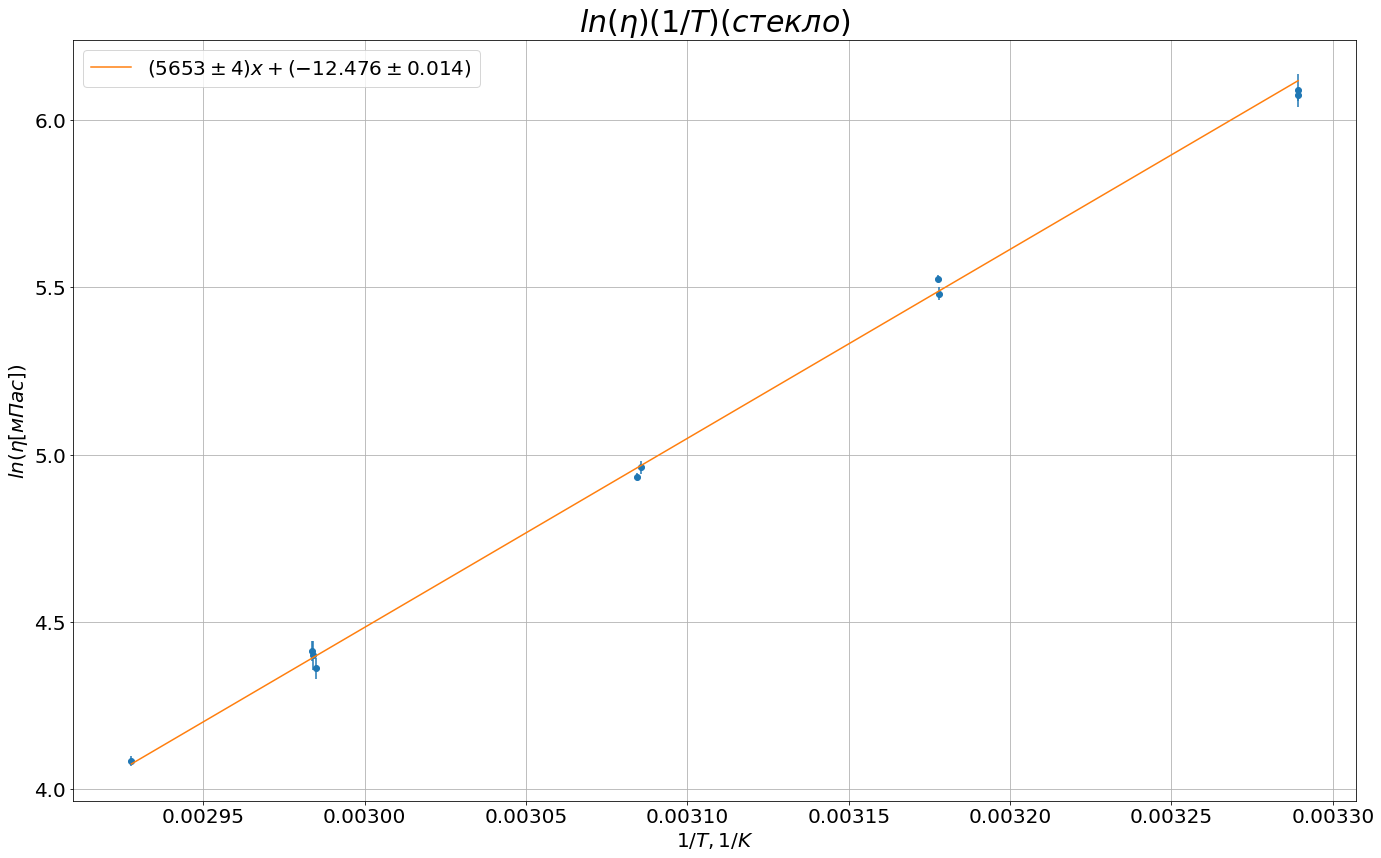

In [19]:
eta_steklo = data['eta'][0:10].to_numpy().astype('float') * 1000
eta_metal = data['eta'][11:].to_numpy().astype('float') * 1000
T_steklo = data['T'][0:10].to_numpy().astype('float')
T_metal = data['T'][11:].to_numpy().astype('float')
deta_steklo = data['deta'][0:10].to_numpy().astype('float') * 1000
deta_metal = data['deta'][11:].to_numpy().astype('float') * 1000

X_s = 1/(T_steklo + 273.16)
Y_s = np.log(eta_steklo)
dY_s = deta_steklo / eta_steklo

X_m = 1/(T_metal + 273.16)
Y_m = np.log(eta_metal)
dY_m = deta_metal / eta_metal


plt.figure(figsize=(23, 14))
plt.rcParams['font.size'] = 20

plt.grid(True)
plt.title(r"$ln(\eta)(1/T) (стекло)$", fontsize=30)
plt.xlabel(r"$1/T, 1/K$", fontsize=20)
plt.ylabel(r"$ln(\eta[мПас])$", fontsize=20)

plt.scatter(X_s, Y_s)
plt.errorbar(X_s, Y_s, xerr=0, yerr=dY_s, linestyle='' )

a, b, da, db = chi_fit(X_s, Y_s, dY_s, sigma=6)

x_min = np.min(X_s)
x_max = np.max(X_s)

plt.plot([x_min, x_max], [a*x_min + b, a*x_max + b], label=fr'$(5653\pm4)x+({b:.3f}\pm{db:.3f})$')
plt.legend(fontsize=20)
plt.savefig('../pictures/steklo.png')
print(a, b, da, db)

Weighted chi_2 : 1.520219824985527
5640.664168060982 -12.529303969386199 4.073999999999695 0.014000000000000005


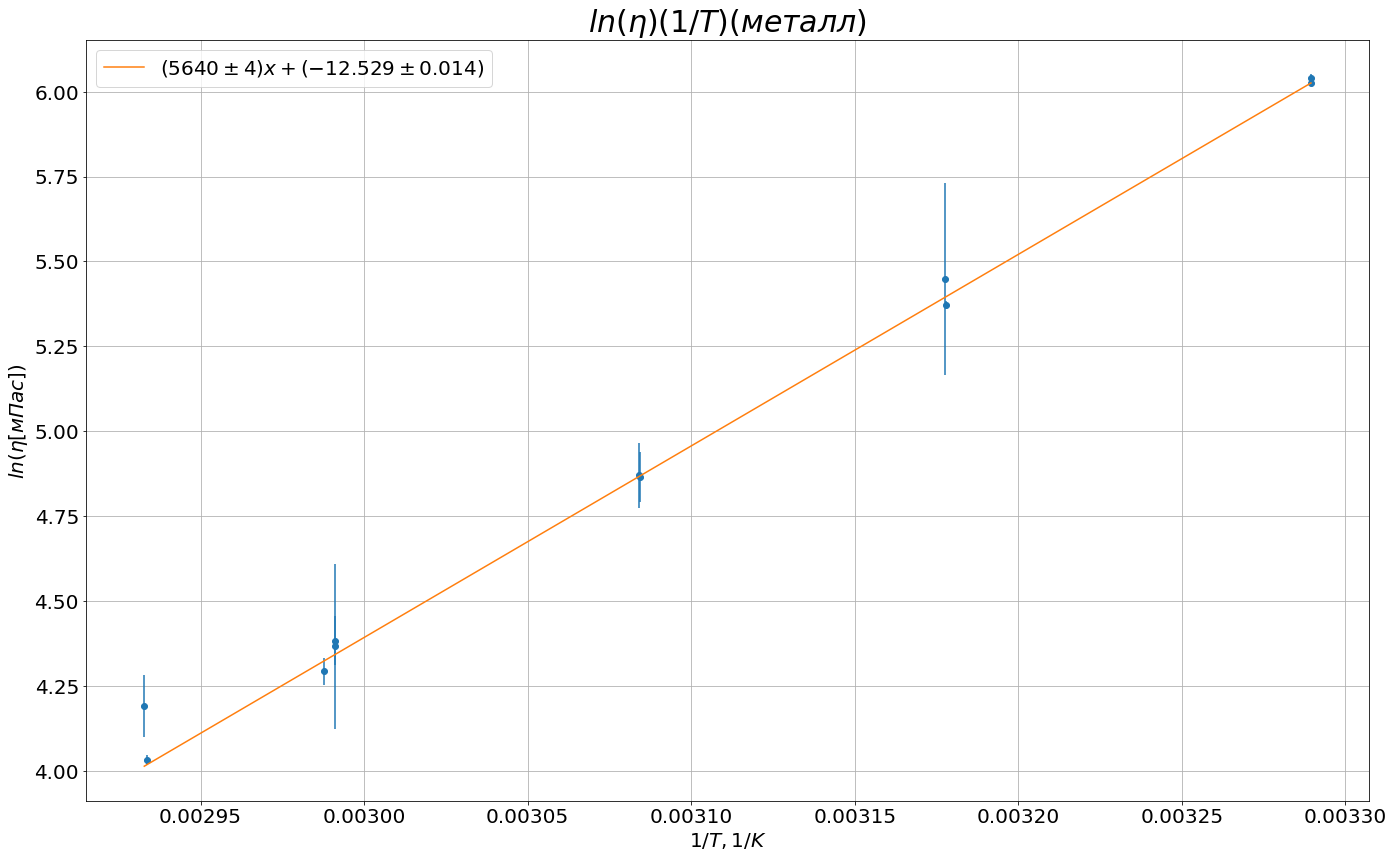

In [20]:
plt.figure(figsize=(23, 14))

plt.grid(True)
plt.rcParams['font.size'] = 20

plt.title(r"$ln(\eta)(1/T) (металл)$", fontsize=30)
plt.xlabel(r"$1/T, 1/K$", fontsize=20)
plt.ylabel(r"$ln(\eta[мПас])$", fontsize=20)
plt.scatter(X_m, Y_m)
plt.errorbar(X_m, Y_m, xerr=0, yerr=dY_m, linestyle='' )

a, b, da, db = chi_fit(X_m, Y_m, dY_m, sigma=6)

x_min = np.min(X_m)
x_max = np.max(X_m)

plt.plot([x_min, x_max], [a*x_min + b, a*x_max + b], label=fr'$(5640\pm4)x+({b:.3f}\pm{db:.3f})$')
plt.legend(fontsize=20)
plt.savefig('../pictures/metal.png')
print(a, b, da, db)

Weighted chi_2 : 8.405029136813301
5470.8269781793415 -18.85406734350361 2.888999999999793 0.010000000000000002


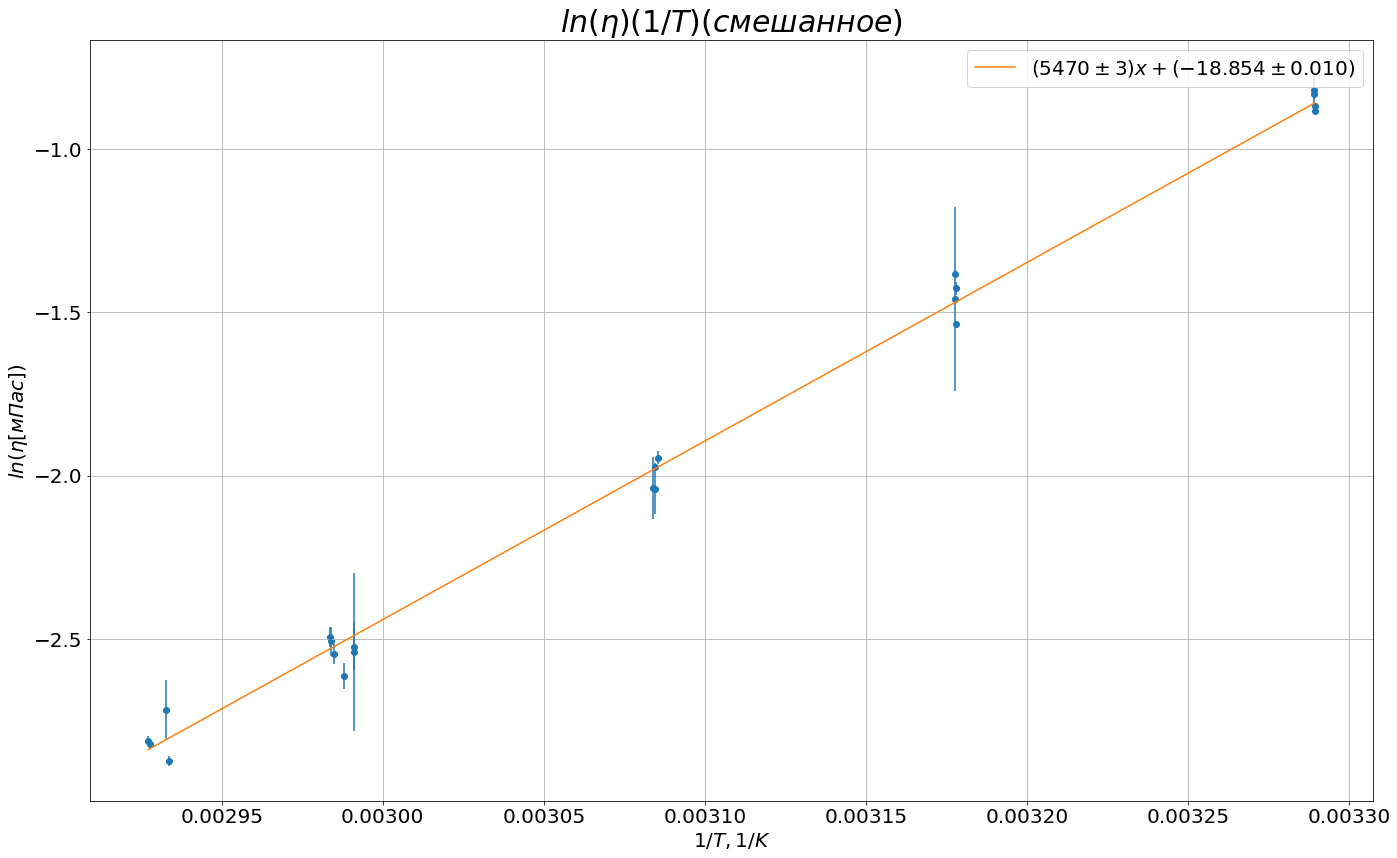

In [21]:
eta = data['eta'].to_numpy().astype('float')
T = data['T'].to_numpy().astype('float')
deta = data['deta'].to_numpy().astype('float')

X = 1/(T + 273.16)
Y = np.log(eta)
dY = deta / eta

plt.figure(figsize=(23, 14))
plt.rcParams['font.size'] = 20

plt.grid(True)
plt.title(r"$ln(\eta)(1/T) (смешанное)$", fontsize=30)
plt.xlabel(r"$1/T, 1/K$", fontsize=20)
plt.ylabel(r"$ln(\eta[мПас])$", fontsize=20)
plt.scatter(X, Y)
plt.errorbar(X, Y, xerr=0, yerr=dY, linestyle='' )

a, b, da, db = chi_fit(X, Y, dY, sigma=6)

x_min = np.min(X)
x_max = np.max(X)

plt.plot([x_min, x_max], [a*x_min + b, a*x_max + b], label=fr'$(5470\pm3)x+({b:.3f}\pm{db:.3f})$')
plt.legend(fontsize=20)
plt.savefig('../pictures/mixed.png')
print(a, b, da, db)

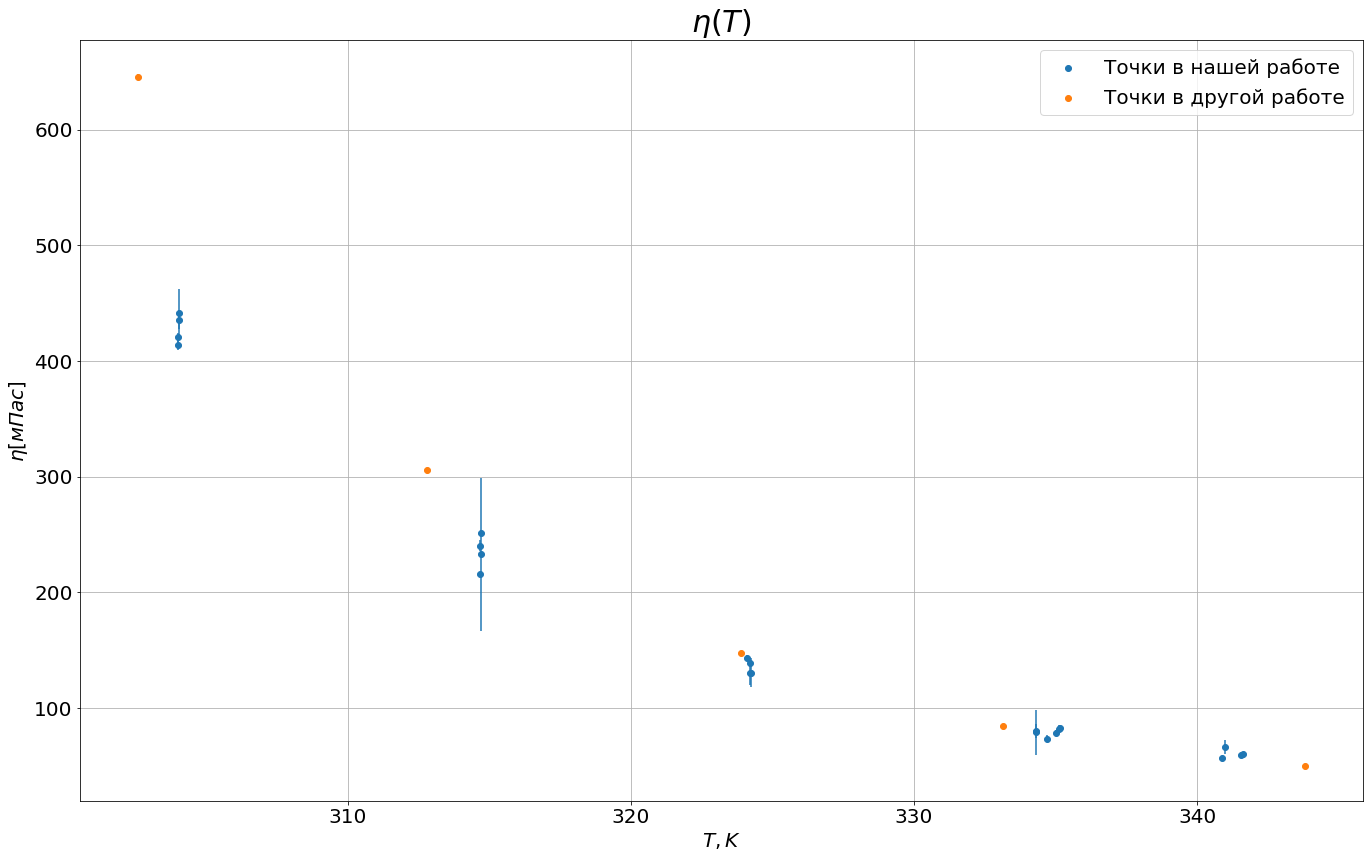

In [29]:
X = data['T'] + 273.16
Y = (data['eta'] * 1000)
dY = data['deta'] * 1000

plt.figure(figsize=(23, 14))
plt.rcParams['font.size'] = 20

plt.grid(True)
plt.title(r"$\eta(T)$", fontsize=30)
plt.xlabel(r"$T, K$", fontsize=20)
plt.ylabel(r"$\eta [мПас]$", fontsize=20)
plt.scatter(X, Y, label='Точки в нашей работе')
plt.errorbar(X, Y, yerr=dY, linestyle='')

X_real = np.array([302.59, 312.81, 323.88, 333.15, 343.80])
Y_real = np.array([645.8 , 305.3 , 147.4 , 84.71 , 49.83])
dY_real = np.array([1.9, 1.9, 0.9, 0.79, 0.24])

plt.scatter(X_real, Y_real, label='Точки в другой работе')
plt.errorbar(X_real, Y_real, yerr=dY_real, linestyle='')

plt.legend()

plt.savefig('../pictures/eta.png')

Weighted chi_2 : 58.97417472165271
6517.008891224456 -15.078678187334564 1.6339999999999308 0.006


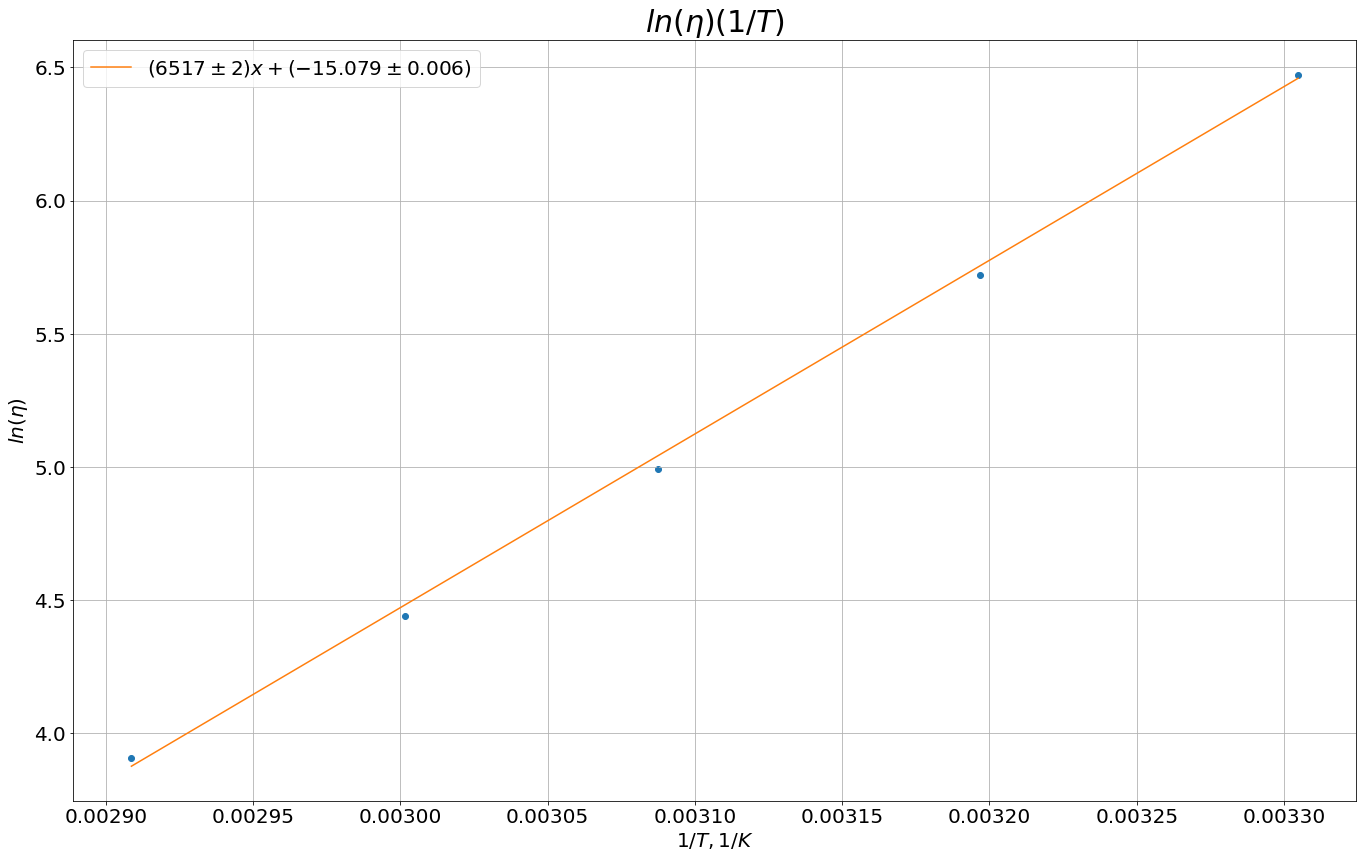

In [30]:
# Это блок с квазитабличными значениями (см. выше).

X = 1/X_real
Y = np.log(Y_real)
dY = dY_real / Y_real

plt.figure(figsize=(23, 14))
plt.rcParams['font.size'] = 20

plt.grid(True)
plt.title(r"$ln(\eta)(1/T)$", fontsize=30)
plt.xlabel(r"$1/T, 1/K$", fontsize=20)
plt.ylabel(r"$ln(\eta)$", fontsize=20)
plt.scatter(X, Y)
plt.errorbar(X, Y, xerr=0, yerr=dY, linestyle='' )

a, b, da, db = chi_fit(X, Y, dY, sigma=6)

x_min = np.min(X)
x_max = np.max(X)

plt.plot([x_min, x_max], [a*x_min + b, a*x_max + b], label=fr'$(6517\pm 2)x+({b:.3f}\pm{db:.3f})$')

plt.legend(fontsize=20)
plt.savefig('../pictures/real.png')
print(a, b, da, db)

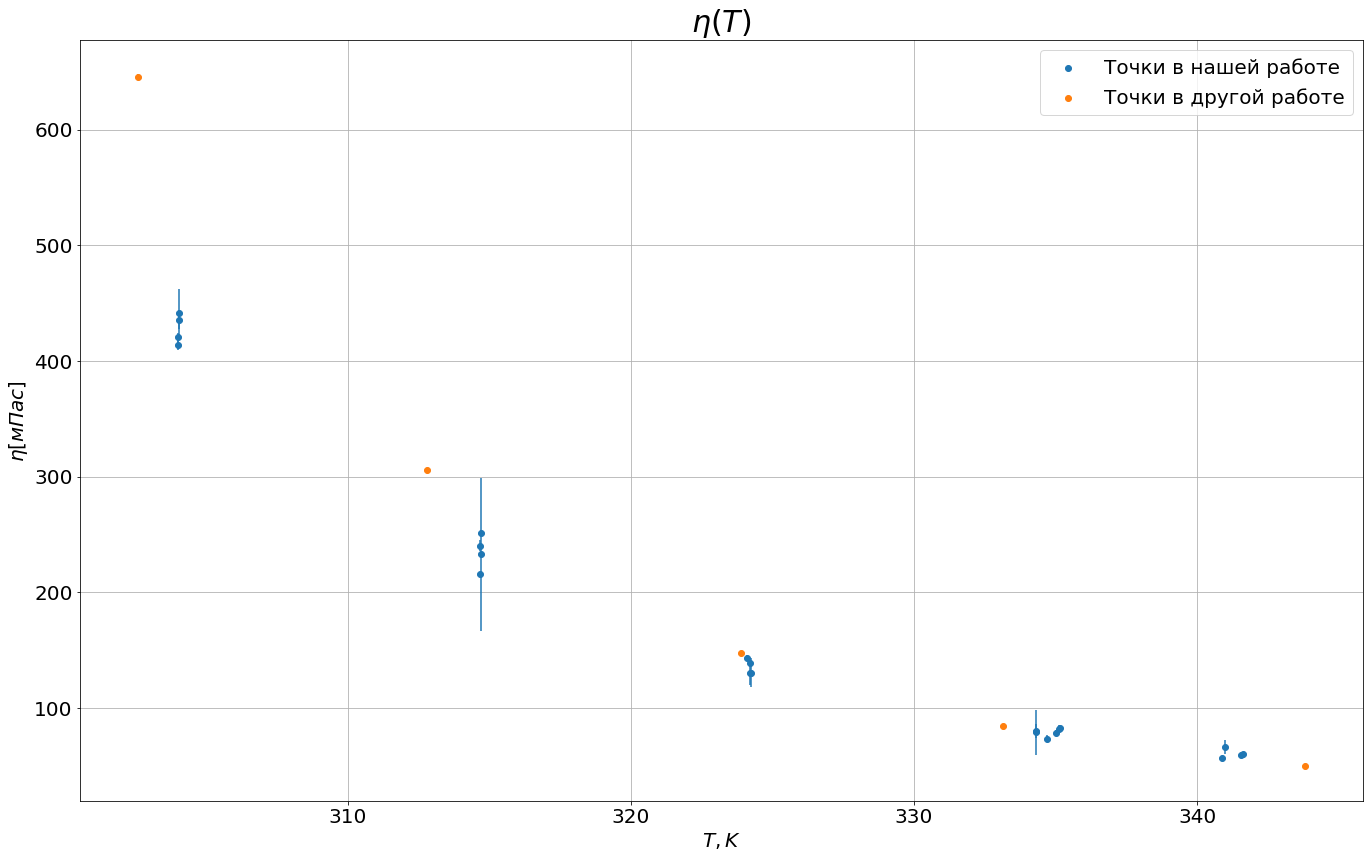

In [32]:
X = data['T'] + 273.16
Y = (data['eta'] * 1000)
dY = data['deta'] * 1000

plt.figure(figsize=(23, 14))
plt.rcParams['font.size'] = 20

plt.grid(True)
plt.title(r"$\eta(T)$", fontsize=30)
plt.xlabel(r"$T, K$", fontsize=20)
plt.ylabel(r"$\eta [мПас]$", fontsize=20)
plt.scatter(X, Y, label='Точки в нашей работе')
plt.errorbar(X, Y, yerr=dY, linestyle='')

plt.scatter(X_real, Y_real, label='Точки в другой работе')
plt.errorbar(X_real, Y_real, yerr=dY_real, linestyle='')
plt.legend(fontsize=20)
plt.savefig('../pictures/eta_full.png')

Weighted chi_2 : 58.97417472165271
6517.008891224456 -15.078678187334564 1.6339999999999308 0.006


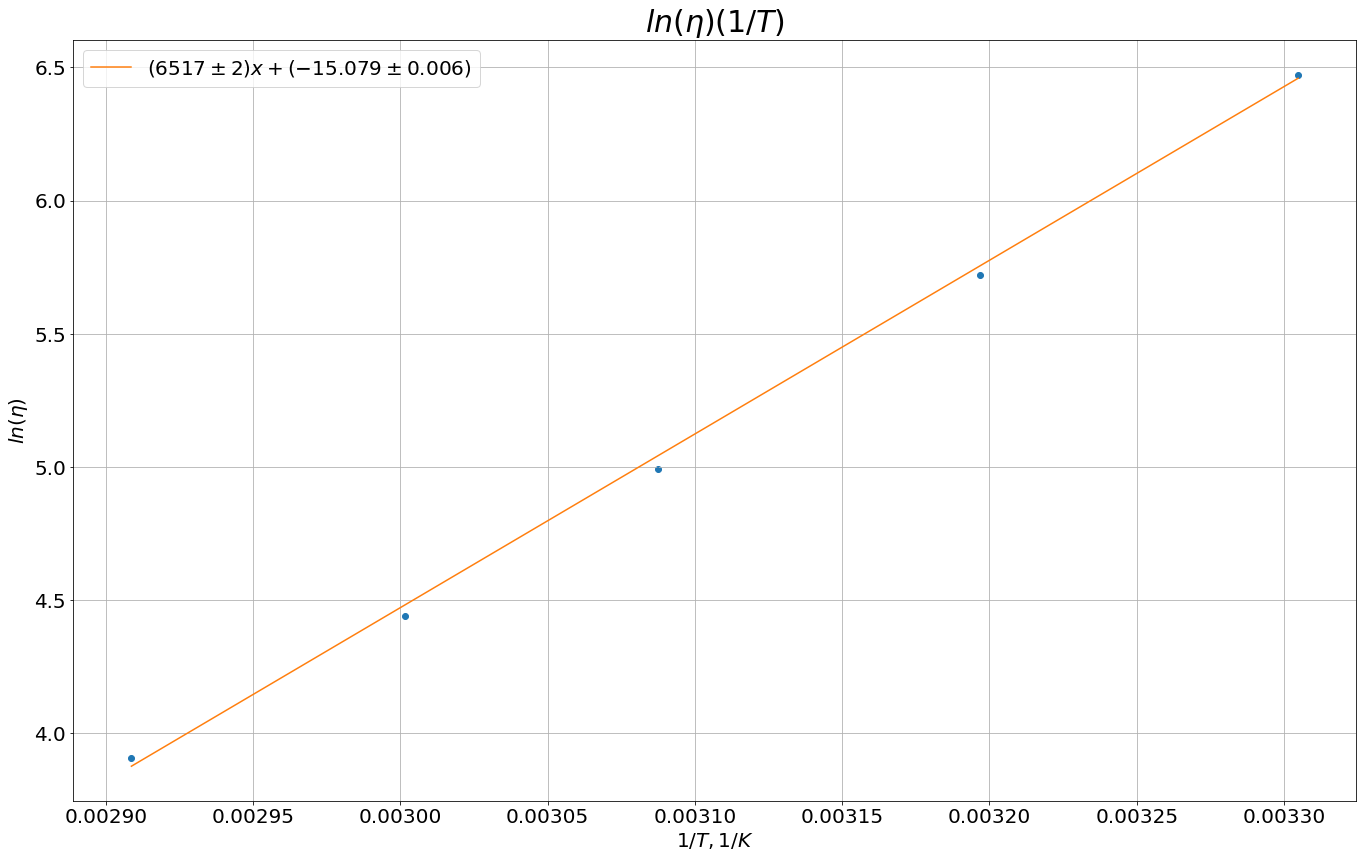

In [34]:
X = 1/X_real
Y = np.log(Y_real)
dY = dY_real / Y_real

plt.figure(figsize=(23, 14))
plt.rcParams['font.size'] = 20

plt.grid(True)
plt.title(r"$ln(\eta)(1/T)$", fontsize=30)
plt.xlabel(r"$1/T, 1/K$", fontsize=20)
plt.ylabel(r"$ln(\eta)$", fontsize=20)
plt.scatter(X, Y)
plt.errorbar(X, Y, xerr=0, yerr=dY, linestyle='' )

a, b, da, db = chi_fit(X, Y, dY, sigma=6)

x_min = np.min(X)
x_max = np.max(X)

plt.plot([x_min, x_max], [a*x_min + b, a*x_max + b], label=fr'$(6517\pm 2)x+({b:.3f}\pm{db:.3f})$')

plt.legend(fontsize=20)
plt.savefig('../pictures/real.png')
print(a, b, da, db)